* HMMを全データで動かしている　教師なしでzoneを推定している


In [1]:
import pandas as pd
df=pd.read_csv("statcast_data_pitch_categori.csv")
pd.set_option('display.max_columns', None)  # カラムの表示制限を解除
pd.set_option('display.width', 1000)        # 横幅も広げる（必要なら）
print(df.head(200))

     Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  release_pos_z    player_name  batter  pitcher     events    description  zone                                                des game_type stand p_throws home_team away_team type  hit_location      bb_type  balls  strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b  on_2b  on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y        vx0         vy0       vz0         ax         ay         az  sz_top  sz_bot  hit_distance_sc  launch_speed  launch_angle  effective_speed  release_spin_rate  release_extension  game_pk  fielder_2  fielder_3  fielder_4  fielder_5  fielder_6  fielder_7  fielder_8  fielder_9  release_pos_y  estimated_ba_using_speedangle  estimated_woba_using_speedangle  woba_value  woba_denom  babip_value  iso_value  launch_speed_angle  at_bat_number  pitch_number       pitch_name  home_score  away_score  bat_score  fld_score  post_away_score  post_home_score  post_bat_score  post_fld_score  \
0    

In [2]:
!pip install hmmlearn


Defaulting to user installation because normal site-packages is not writeable


In [3]:
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM
from hmmlearn.hmm import GaussianHMM
import numpy as np

In [31]:
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM
import numpy as np

# --- 1. データ準備 ---
# 各投手ごとのzone系列と長さをリストにまとめる
all_zone_data = []
lengths = []

for _, group in df.groupby("pitcher"):
    zone_seq = group["zone"].dropna().astype(int).values
    if len(zone_seq) < 10:
        continue  # 短すぎるデータは除外
    all_zone_data.append(zone_seq.reshape(-1, 1))
    lengths.append(len(zone_seq))

# --- 2. 投手単位で学習／テストに分割 ---
# 累積長さで分ける（途中で切らない）
total_length = sum(lengths)
split_point = int(total_length * 0.7)

train_data = []
test_data = []
train_lengths = []
test_lengths = []

cumsum = 0
for seq, l in zip(all_zone_data, lengths):
    if cumsum + l <= split_point:
        train_data.append(seq)
        train_lengths.append(l)
        cumsum += l
    else:
        test_data.append(seq)
        test_lengths.append(l)

# データを結合
X_train = np.concatenate(train_data)
X_test = np.concatenate(test_data)

# --- 3. モデル定義・学習 ---
model = CategoricalHMM(n_components=13,init_params="ste", n_iter=100, random_state=42)
model.fit(X_train, train_lengths)

# --- 4. テストデータに対する予測 ---
hidden_states = model.predict(X_test)

# --- 5. 評価と出力 ---
log_likelihood = model.score(X_test)
print("テストデータに対する対数尤度（score）:", log_likelihood)
print("zone（観測値）:", X_test.ravel()[:30])
print("隠れ状態（構え位置など）:", hidden_states[:30])


テストデータに対する対数尤度（score）: -2363577.2071801764
zone（観測値）: [ 3 13  4  4 11 13 12 13 12 11 13  5 13  1 12  8  5  2  2  1 11 12 13 11
 13  3 12  2  2  5]
隠れ状態（構え位置など）: [ 1  0 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12]


In [32]:
avg_train_score = model.score(X_train) / sum(train_lengths)
avg_test_score = model.score(X_test) / sum(test_lengths)

print("Train avg score:", avg_train_score)
print("Test avg score:", avg_test_score)


Train avg score: -2.4034168257925206
Test avg score: -2.409787288219065


In [33]:
print("初期状態確率:")
print(model.startprob_)

初期状態確率:
[3.12607896e-02 1.58381353e-01 5.06349921e-07 4.35966008e-09
 1.49912330e-01 4.94935760e-20 2.85372710e-01 1.96982919e-01
 3.17398920e-04 1.66641297e-02 7.81918634e-02 4.68400318e-05
 8.28691552e-02]


In [34]:
print("遷移確率行列:")
print(model.transmat_)

遷移確率行列:
[[8.03442568e-10 9.59705843e-04 1.35653182e-06 2.08635382e-16
  1.58257180e-04 9.17037672e-11 1.05991419e-02 1.09365797e-13
  6.01557615e-20 2.57631219e-08 3.36004929e-08 1.30467711e-07
  9.88281348e-01]
 [8.64498425e-01 3.00345821e-03 2.14924977e-16 3.10765710e-18
  2.74293659e-08 1.50448601e-03 1.18380631e-07 2.50408922e-12
  1.95619624e-15 4.23509027e-02 1.95513176e-30 1.10379499e-04
  8.85322025e-02]
 [2.30131882e-09 2.74019007e-04 2.06603993e-06 7.34863095e-09
  7.79633631e-02 9.04375435e-01 1.35862698e-13 1.73725462e-02
  1.23559289e-05 2.05257171e-07 1.05146583e-22 1.11728298e-19
  2.75601817e-10]
 [1.13682718e-01 2.77125772e-06 7.91096066e-11 1.27448539e-07
  1.38399091e-03 3.39674474e-05 8.20210857e-01 4.32058576e-02
  2.11954326e-02 4.33861539e-07 3.80340542e-09 2.83839984e-04
  7.24581723e-29]
 [1.96590632e-09 3.37305224e-16 1.06501097e-01 7.70786071e-07
  1.03646999e-06 3.01738209e-01 1.30274242e-06 6.57259924e-09
  6.47147129e-08 1.36976570e-21 5.62855490e-14 5.917

In [35]:
print("出力確率:")
print(model.emissionprob_)

出力確率:
[[0.         0.07095344 0.06359129 0.02761785 0.06619778 0.05287281
  0.02248393 0.03301659 0.04594761 0.02527813 0.         0.27114673
  0.0762089  0.07224502 0.17243992]
 [0.         0.10634605 0.07900849 0.03013405 0.10118093 0.10616614
  0.06107559 0.04614047 0.03669802 0.0485036  0.         0.16783092
  0.07041237 0.08349994 0.06300343]
 [0.         0.06289162 0.06527376 0.09048089 0.09111455 0.08530613
  0.11671741 0.02666915 0.07423912 0.05141712 0.         0.06693167
  0.04861341 0.14635678 0.07398838]
 [0.         0.02694397 0.04878417 0.04977973 0.04084552 0.14365632
  0.15482303 0.04962841 0.19691566 0.13889827 0.         0.01137232
  0.02684727 0.00272556 0.10877978]
 [0.         0.04004018 0.06691483 0.05482103 0.07100446 0.0854578
  0.07055937 0.07014792 0.07372174 0.05097075 0.         0.05615313
  0.10199571 0.17464431 0.08356878]
 [0.         0.03686116 0.03331607 0.03340883 0.0397031  0.05787974
  0.0486976  0.04656052 0.03552083 0.02913959 0.         0.10448585

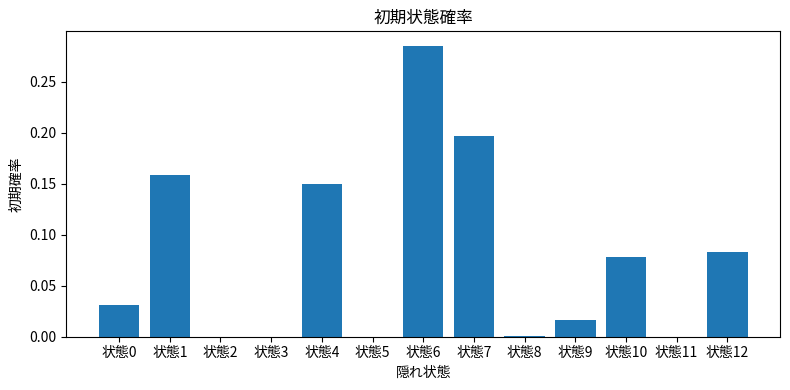

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 初期状態確率（例の値）
start_prob = model.startprob_  # もしくは直接貼り付けてもOK
n_states = len(start_prob)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(n_states), start_prob)
plt.xlabel("隠れ状態")
plt.ylabel("初期確率")
plt.title("初期状態確率")
plt.xticks(np.arange(n_states), [f"状態{i}" for i in range(n_states)])
plt.tight_layout()
plt.show()


<Axes: >

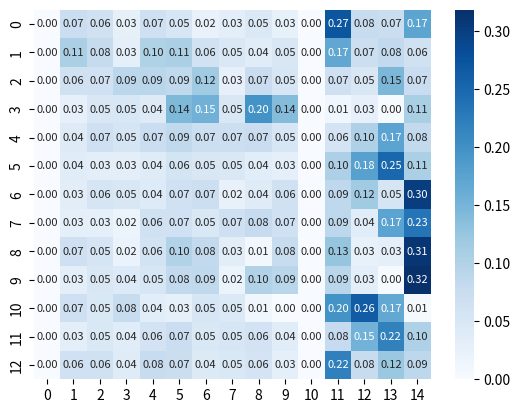

In [37]:
import seaborn as sns
sns.heatmap(model.emissionprob_, annot=True,annot_kws={"size": 8}, cmap="Blues",fmt=".2f")


In [38]:
import numpy as np
most_likely_zone_per_state = np.argmax(model.emissionprob_, axis=1)
zone_labels = np.arange(15)  # 0〜14 → zone番号
true_zone_numbers = zone_labels[most_likely_zone_per_state]

print("各構え状態から最も出やすい zone:")
print(true_zone_numbers[1:])  # zone0は無視してOK


各構え状態から最も出やすい zone:
[11 13  8 13 13 14 14 14 14 12 13 11]


In [12]:
print(model.monitor_.converged)  


True


In [39]:
import matplotlib.pyplot as plt

zones, counts = np.unique(zone_data, return_counts=True)
plt.bar(zones.ravel(), counts)
plt.title("zoneごとの出現頻度")
plt.xlabel("zone")
plt.ylabel("回数")
plt.show()


NameError: name 'zone_data' is not defined

In [ ]:
model.startprob_


array([3.31594401e-26, 8.22284241e-15, 1.30534896e-72, 1.88443124e-06,
       5.35644106e-21, 7.48646691e-58, 5.37848059e-48, 9.99998115e-01,
       2.21149872e-10, 2.87533729e-30, 4.14392571e-30, 7.19217722e-15,
       7.72612551e-45])

<Axes: >

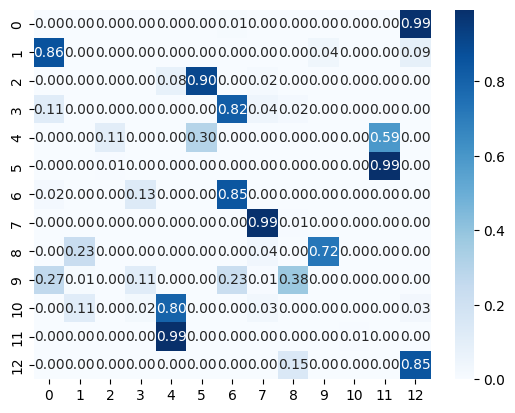

In [13]:
import seaborn as sns
sns.heatmap(model.transmat_, annot=True, cmap="Blues",fmt=".2f")


[11 13  6 13 13 14 14 14 14 13 13 11]

In [14]:
print(hidden_states)

[ 1  0 12 ...  7  7  7]


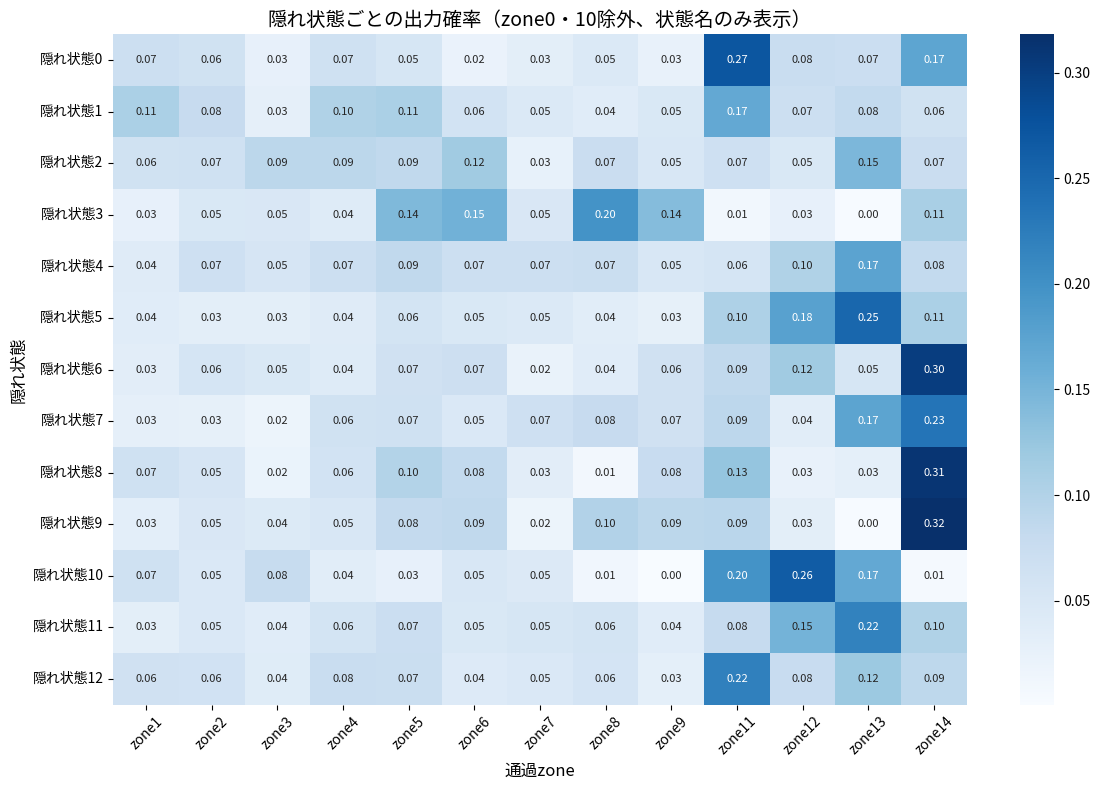

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 日本語フォント設定
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False

# zone0と10を除外
exclude_indices = [0, 10]
include_indices = [i for i in range(model.emissionprob_.shape[1]) if i not in exclude_indices]

# 出力確率とラベル生成
emission_filtered = model.emissionprob_[:, include_indices]
zone_labels = [f"zone{z}" for z in include_indices]
state_labels = [f"隠れ状態{i}" for i in range(emission_filtered.shape[0])]

# プロット
plt.figure(figsize=(12, 8))
sns.heatmap(emission_filtered,
            annot=True, fmt=".2f", cmap="Blues",
            xticklabels=zone_labels, yticklabels=state_labels,
            annot_kws={"size": 8})
plt.title("隠れ状態ごとの出力確率（zone0・10除外、状態名のみ表示）", fontsize=14)
plt.xlabel("通過zone", fontsize=12)
plt.ylabel("隠れ状態", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [115]:
import matplotlib.font_manager as fm

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)


/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoPMincho.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc
/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc
/usr/share/fonts/meiryo/meiryo.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/meiryo/meiryob.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Light.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiObl

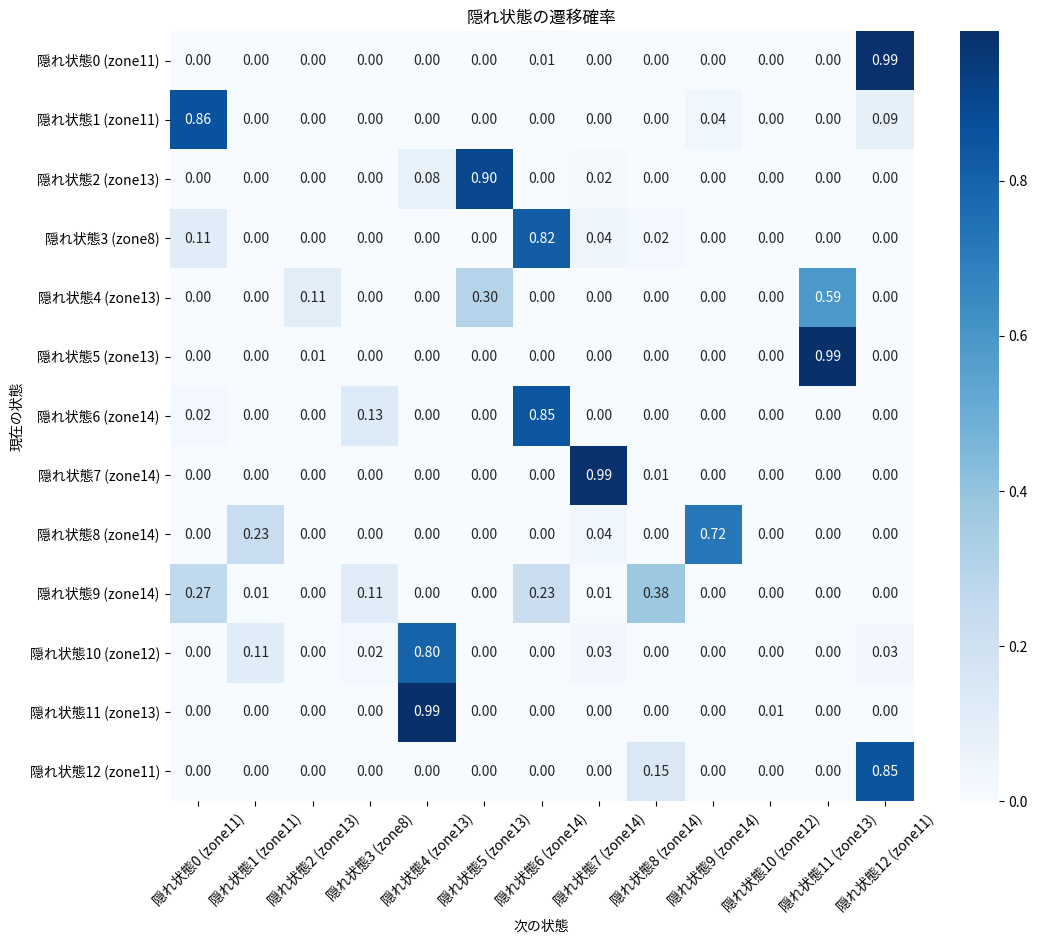

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

#zone_labels = [f"zone{z}" for z in true_zone_numbers]  # 仮に構え状態の代表zoneをラベルに
state_labels = [f"隠れ状態{i} (zone{z})" for i, z in enumerate(most_likely_zones)]

plt.figure(figsize=(12, 10))
sns.heatmap(model.transmat_, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=state_labels, yticklabels=state_labels,
            annot_kws={"size": 10})
plt.title("隠れ状態の遷移確率")
plt.xlabel("次の状態")
plt.ylabel("現在の状態")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


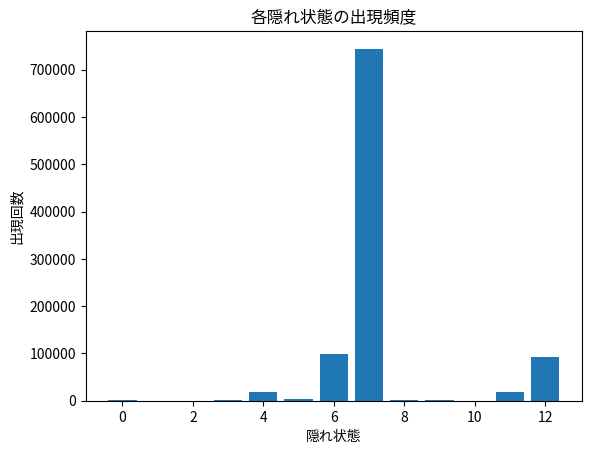

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# hidden_states は model.decode(test_data) などで得られた隠れ状態の列（1次元配列）
unique, counts = np.unique(hidden_states, return_counts=True)

# 結果を棒グラフで可視化
plt.bar(unique, counts)
plt.xlabel("隠れ状態")
plt.ylabel("出現回数")
plt.title("各隠れ状態の出現頻度")
plt.show()


In [4]:
# GaussianHMM
from sklearn.preprocessing import OneHotEncoder

# zone, pitch_type を文字列化して One-Hot
ohe = OneHotEncoder(sparse_output=False)
X_cat = ohe.fit_transform(df[["zone", "pitch_type"]].astype(str))

In [3]:
#df["zone_filled"] = df["zone"].fillna(99).astype(int)
df["obs"] = df["zone"].astype(str) + "_" + df["pitch_cluster_label"].astype(str)

# 例えば zone: 1〜14, 球種: 10種類 として
#df["obs"] = df["zone"].astype(str) + "_" + df["pitch_cluster_label"].astype(str)

# カテゴリを整数に変換
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["obs_encoded"] = le.fit_transform(df["obs"])


In [5]:
# GaussianHMM
# One-hot のカラム名を付けて DataFrame にする
onehot_columns = ohe.get_feature_names_out(["zone", "pitch_type"])
df_onehot = pd.DataFrame(X_cat, columns=onehot_columns, index=df.index)

# 元の df と結合
df = pd.concat([df, df_onehot], axis=1)


In [6]:
# GaussianHMM
train_seqs, test_seqs = [], []
train_lengths, test_lengths = [], []

onehot_cols = list(onehot_columns)  # zone_1, pitch_type_FF などの列名

for pid, pitcher_df in df.groupby("pitcher"):
    games = pitcher_df["game_pk"].unique()
    
    if pitcher_df.shape[0] < 10 or len(games) < 2:
        continue
    
    train_games, test_games = train_test_split(games,shuffle=False, test_size=0.3, random_state=42)
    
    for g in train_games:
        seq = pitcher_df[pitcher_df["game_pk"] == g][onehot_cols].dropna().values
        if len(seq) < 1:
            continue
        train_seqs.append(seq)
        train_lengths.append(len(seq))
        
    for g in test_games:
        seq = pitcher_df[pitcher_df["game_pk"] == g][onehot_cols].dropna().values
        if len(seq) < 1:
            continue
        test_seqs.append(seq)
        test_lengths.append(len(seq))

X_train = np.concatenate(train_seqs)
X_test = np.concatenate(test_seqs)


In [ ]:
#\itcher_ids = df["pitcher"].unique()
#train_ids, test_ids = train_test_split(pitcher_ids,shuffle=False, test_size=0.3, random_state=42)

train_seqs, test_seqs = [], []
train_lengths, test_lengths = [], []

for pid, pitcher_df in df.groupby("pitcher"):
    games = pitcher_df["game_pk"].unique()
    
    # 10球未満の投手はスキップ（任意）
    if pitcher_df.shape[0] < 10 or len(games) < 2:
        continue
    
    train_games, test_games = train_test_split(games, test_size=0.3, random_state=42)
    
    for g in train_games:
        seq = pitcher_df[pitcher_df["game_pk"] == g]["obs_encoded"].dropna().values.reshape(-1, 1)
        if len(seq) < 1:
            continue
        train_seqs.append(seq)
        train_lengths.append(len(seq))
        
    for g in test_games:
        seq = pitcher_df[pitcher_df["game_pk"] == g]["obs_encoded"].dropna().values.reshape(-1, 1)
        if len(seq) < 1:
            continue
        test_seqs.append(seq)
        test_lengths.append(len(seq))

X_train = np.concatenate(train_seqs)
X_test = np.concatenate(test_seqs)

In [7]:
# GaussianHMM
model = GaussianHMM(n_components=6, covariance_type="diag", n_iter=100, random_state=42)
model.fit(X_train, train_lengths)

Model is not converging.  Current: 273756737.4201915 is not greater than 273756737.4201916. Delta is -5.960464477539063e-08


GaussianHMM(n_components=6, n_iter=100, random_state=42)

In [192]:
model = CategoricalHMM(n_components=5, n_iter=100, random_state=42)
model.fit(X_train, train_lengths)


CategoricalHMM(n_components=5, n_features=np.int64(56), n_iter=100,
               random_state=RandomState(MT19937) at 0x7FB798CA6F40)

In [8]:
hidden_states = model.predict(X_test, test_lengths)
log_likelihood = model.score(X_test, test_lengths)

In [9]:
print("初期状態確率:")
print(model.startprob_)

初期状態確率:
[0.03202884 0.74897638 0.06962082 0.08396629 0.02432946 0.04107821]


/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 38560 (\N{CJK UNIFIED IDEOGRAPH-96A0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3587517/1248494809.py:14: UserWarning: Glyph 30906 (\N{CJK UNIFIED ID

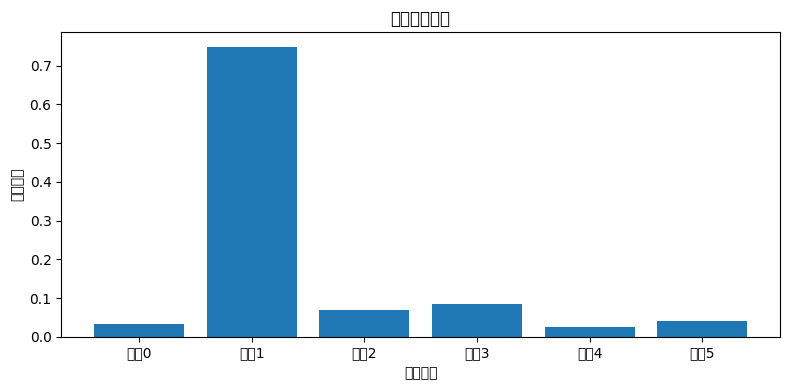

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 初期状態確率（例の値）
start_prob = model.startprob_  # もしくは直接貼り付けてもOK
n_states = len(start_prob)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(n_states), start_prob)
plt.xlabel("隠れ状態")
plt.ylabel("初期確率")
plt.title("初期状態確率")
plt.xticks(np.arange(n_states), [f"状態{i}" for i in range(n_states)])
plt.tight_layout()
plt.show()


In [11]:
print("遷移確率行列:")
print(model.transmat_)

遷移確率行列:
[[0.27261    0.48443375 0.03467994 0.1144855  0.06170655 0.03208426]
 [0.0471455  0.68590869 0.04436173 0.06229353 0.09578705 0.0645035 ]
 [0.04383154 0.51994447 0.1743739  0.09720368 0.10616579 0.05848063]
 [0.07012502 0.39745174 0.05113762 0.33719404 0.08364229 0.0604493 ]
 [0.02822482 0.53826944 0.04431851 0.0724938  0.25929442 0.05739901]
 [0.0263593  0.51277412 0.03863743 0.078036   0.11221886 0.2319743 ]]


In [12]:
print("出力確率:")
print(model.emissionprob_)

出力確率:


AttributeError: 'GaussianHMM' object has no attribute 'emissionprob_'

In [13]:
import pandas as pd

# 状態遷移確率を表に
trans_df = pd.DataFrame(model.transmat_,
                        columns=[f"状態{j}" for j in range(model.n_components)],
                        index=[f"状態{i}" for i in range(model.n_components)])

# 出力確率（観測カテゴリ名つき）を表に
obs_labels = le.inverse_transform(np.arange(model.emissionprob_.shape[1]))
emit_df = pd.DataFrame(model.emissionprob_,
                       columns=obs_labels,
                       index=[f"状態{i}" for i in range(model.n_components)])


NameError: name 'le' is not defined

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(trans_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("状態遷移確率（transmat_）")
plt.xlabel("次の状態")
plt.ylabel("現在の状態")
plt.tight_layout()
plt.show()


NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [200]:
obs_labels = le.inverse_transform(np.arange(model.emissionprob_.shape[1]))

# zoneとpitch_clusterを分解
zone_list = []
pitch_list = []
for obs in obs_labels:
    z, p = obs.split("_")
    zone_list.append(float(z))
    pitch_list.append(p)


In [201]:
import pandas as pd

n_states = model.n_components
emission = model.emissionprob_

zone_df = pd.DataFrame(0, index=[f"状態{i}" for i in range(n_states)],
                       columns=sorted(set(zone_list)))

# 状態ごとにzoneごとに足しこむ
for idx, zone in enumerate(zone_list):
    zone_df[zone] += emission[:, idx]


In [202]:
pitch_df = pd.DataFrame(0, index=[f"状態{i}" for i in range(n_states)],
                        columns=sorted(set(pitch_list)))

for idx, pitch in enumerate(pitch_list):
    pitch_df[pitch] += emission[:, idx]


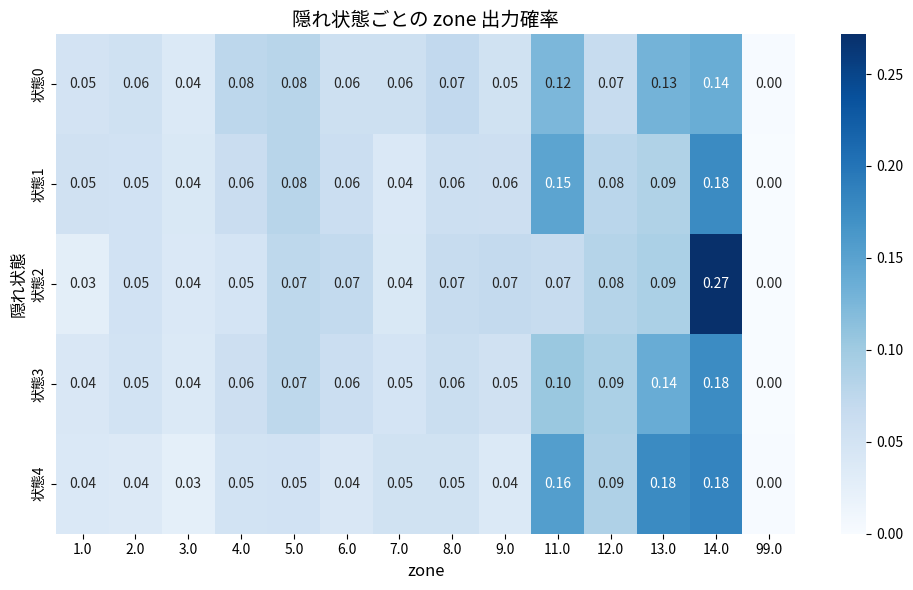

In [203]:
plt.figure(figsize=(10, 6))
sns.heatmap(zone_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("隠れ状態ごとの zone 出力確率", fontsize=14)
plt.xlabel("zone", fontsize=12)
plt.ylabel("隠れ状態", fontsize=12)
plt.tight_layout()
plt.show()


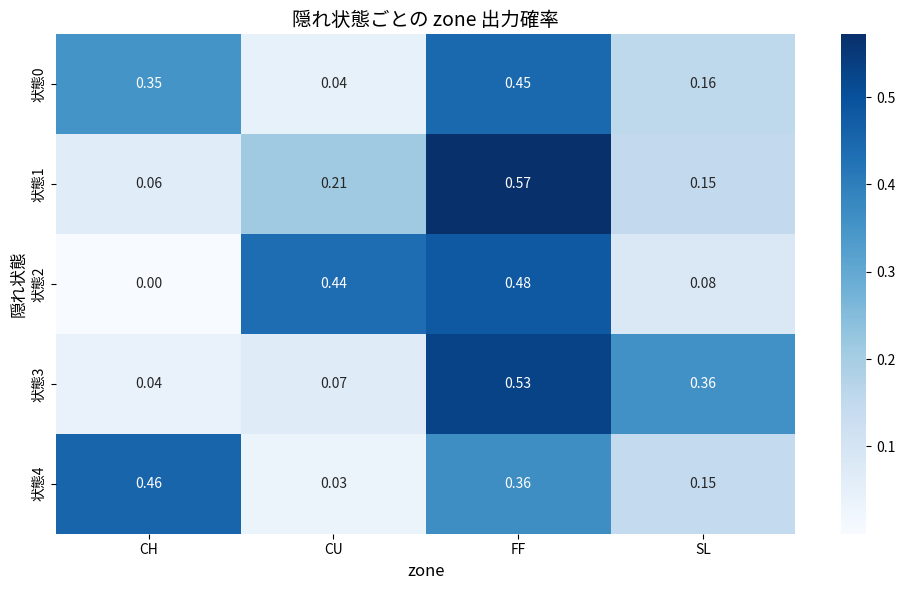

In [204]:
plt.figure(figsize=(10, 6))
sns.heatmap(pitch_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("隠れ状態ごとの zone 出力確率", fontsize=14)
plt.xlabel("zone", fontsize=12)
plt.ylabel("隠れ状態", fontsize=12)
plt.tight_layout()
plt.show()


In [205]:
last_state = hidden_states[-1]
pred_obs_encoded = np.argmax(model.emissionprob_[last_state])
zone_pred, pitch_pred = le.inverse_transform([pred_obs_encoded])[0].split("_")

# --- ⑦ 結果表示 ---
print("テスト対数尤度:", log_likelihood)
print("最後の隠れ状態:", last_state)
print("次に予測される zone:", zone_pred)
print("次に予測される pitch_cluster:", pitch_pred)

テスト対数尤度: -3642829.681455527
最後の隠れ状態: 3
次に予測される zone: 14
次に予測される pitch_cluster: SL


In [206]:
df["pitch_cluster_label"].isna().sum()

np.int64(0)

In [207]:
obs_seq, state_seq = model.sample(10)

# カテゴリ番号 → 実際の zone と pitch_cluster に戻す
decoded = le.inverse_transform(obs_seq.ravel())

for i, (obs, state) in enumerate(zip(decoded, state_seq)):
    zone, pitch = obs.split("_")
    print(f"{i+1}球目: 状態{state} → zone{zone}, pitch={pitch}")


1球目: 状態4 → zone13, pitch=CH
2球目: 状態0 → zone11, pitch=FF
3球目: 状態4 → zone11, pitch=CH
4球目: 状態0 → zone2, pitch=FF
5球目: 状態1 → zone2, pitch=SL
6球目: 状態0 → zone11, pitch=FF
7球目: 状態4 → zone13, pitch=CU
8球目: 状態0 → zone2, pitch=FF
9球目: 状態4 → zone12, pitch=FF
10球目: 状態0 → zone11, pitch=FF
